In [1]:
import pandas as pd
import numpy as np

# First Download,Clean, and Parse Data. Then identify the top 10(arbitrary) most used tickers

In [2]:
filepath = '//Users/yashpatel/Desktop/jori/sec-edgar-filings/0000806628/NPORT-P/0001752724-23-286202/full-submission.xml'

In [3]:
namespaces = {
    'ns': 'http://www.sec.gov/edgar/nport',
    'com': 'http://www.sec.gov/edgar/common',
    'ncom': 'http://www.sec.gov/edgar/nportcommon',
    'xsi': 'http://www.w3.org/2001/XMLSchema-instance'
}

df = pd.read_xml(filepath, xpath="//ns:invstOrSec", namespaces=namespaces)


# %%
df.to_csv('DNP_portfolio_holdings.csv')


In [4]:
url = 'https://raw.githubusercontent.com/yoshishima/Stock_Data/master/StockCUSIPList.csv'
# Read the CSV file into a pandas DataFrame
maps = pd.read_csv(url, sep=",", header=0)
# maps.to_csv('StockCUSIPList.csv')

# %%
df.info()

# %%
maps

# %%
df['cusip'] = df['cusip'].astype(str)
maps['CUSIP'] = maps['CUSIP'].astype(str)

merged_df = df.merge(maps, left_on='cusip', right_on='CUSIP', how='right')

# Display the first few rows to verify the merge
merged_df

# %%
# Assuming 'df' is your DataFrame
# Update 'CUSIP' for rows where 'Symbol' is 'AMZN'
def add_mapping(df):
    df.loc[df['Symbol'] == 'AMZN', 'CUSIP'] = df.loc[df['Symbol'] == 'AMZN', 'CUSIP'].astype(str).str.zfill(9)

    # Now only the 'CUSIP' for 'AMZN' will be updated
    print(df[df['Symbol'] == 'AMZN'])
    return df
maps = add_mapping(maps)

# %%
df['cusip'] = df['cusip'].str.strip()
maps['CUSIP'] = maps['CUSIP'].str.strip()
df['cusip'] = df['cusip'].astype(str)
maps['CUSIP'] = maps['CUSIP'].astype(str)

# %%
# merged_df = df.merge(maps, left_on='cusip', right_on='CUSIP', how='left')

# %%
merged_df.sort_values('valUSD', ascending=False).head()

# %%
merged_df.sort_values('valUSD', ascending=False).head(10)['pctVal'].sum()

# %%
# Assuming merged_df is your DataFrame after the merge
top_symbols = merged_df.sort_values('valUSD', ascending=False).head(50)
top_symbols['Symbol'] = top_symbols['Symbol'].astype(str).str.strip()
top_symbols = top_symbols.dropna(subset=['Symbol'])
# Filter out rows where 'Symbol' is the string 'nan'
top_symbols = top_symbols[top_symbols['Symbol'].astype(str).str.lower() != 'nan']

#top_symbols['Symbol']
print(top_symbols[['Symbol','valUSD', 'pctVal']])
#print(top_symbols.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 134 non-null    object 
 1   lei                  125 non-null    object 
 2   title                134 non-null    object 
 3   cusip                134 non-null    object 
 4   identifiers          0 non-null      float64
 5   balance              134 non-null    float64
 6   units                134 non-null    object 
 7   curCd                123 non-null    object 
 8   valUSD               134 non-null    float64
 9   pctVal               134 non-null    float64
 10  payoffProfile        134 non-null    object 
 11  assetCat             134 non-null    object 
 12  issuerCat            134 non-null    object 
 13  invCountry           134 non-null    object 
 14  isRestrictedSec      134 non-null    object 
 15  fairValLevel         134 non-null    int

In [5]:
import yfinance as yf

In [6]:
y_tix = top_symbols['Symbol'].values[:10] #Extract top 10 values
y_tix = ''.join(i+',' for i in y_tix)[:-1] #Make the symbols into a string to download all data
y_data = yf.download(y_tix, start = '2016-01-01')[['Adj Close']]
y_data = y_data.dropna(axis=0)
print(len(y_data))
print(y_data)

[*********************100%***********************]  10 of 10 completed
2017
            Adj Close                                                          \
                  CMS        CNP         LNG         NI        OGE        PEG   
Date                                                                            
2016-01-04  28.183243  13.829148   36.651688  15.119620  18.736328  29.202812   
2016-01-05  28.404840  13.957829   37.589722  15.359741  18.566574  29.376358   
2016-01-06  28.444420  13.783731   36.211987  15.444942  18.405746  29.134888   
2016-01-07  28.618544  13.511236   34.169807  15.104132  18.034052  29.285810   
2016-01-08  28.571053  13.480955   34.208885  15.080892  18.234194  28.991508   
...               ...        ...         ...        ...        ...        ...   
2024-01-02  59.209999  29.010000  169.410004  27.010000  34.995743  61.540001   
2024-01-03  59.290001  29.129999  169.360001  26.889999  35.163757  61.810001   
2024-01-04  59.380001  29.080000 

# Now that we have the top tickers, hold them to the side, and download the CEF and NAV data

### We will extract std and means of each time series to compute z-scores, and use those as a simple trading signal

In [7]:
cef_data = yf.download(["DNP", "XDNPX"], start = '2016-01-01')['Adj Close']

[*********************100%***********************]  2 of 2 completed


In [8]:
dates = cef_data.index.values
dates

array(['2016-01-04T00:00:00.000000000', '2016-01-05T00:00:00.000000000',
       '2016-01-06T00:00:00.000000000', ...,
       '2024-01-04T00:00:00.000000000', '2024-01-05T00:00:00.000000000',
       '2024-01-08T00:00:00.000000000'], dtype='datetime64[ns]')

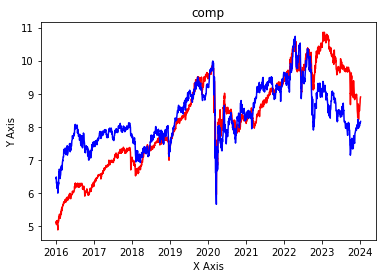

In [9]:
import matplotlib.pyplot as plt


prices = []
prices.append(cef_data['DNP'])
prices.append(cef_data['XDNPX'])


plt.plot(dates, prices[0], color = 'r')
plt.plot(dates, prices[1], color = 'b')



# Add a title and labels
plt.title("comp")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")

# Show the plot
plt.show()


In [10]:
import math
import statistics
from statistics import mean
cef_std = prices[0].std()
nav_std = prices[1].std()
cef_p = prices[0]
nav_p = prices[1]
cef_m = mean(cef_p)
nav_m = mean(nav_p)
print(nav_std, cef_std)
print(nav_m, cef_m)
spread = [abs(nav_p[i]-cef_p[i]) for i in range(len(nav_p))]
spread_m = mean(spread)
print(spread_m) #I also extract the spread values, and its mean and std, however it was not used
print(spread[0])

0.8631816553366147 1.3988394108731461
8.310324477865723 8.20396810672516
0.6699201383387386
1.3679404258728027


In [11]:
def z_score(price, mean, std):
    return (price-mean)/std
        

In [12]:
dates = cef_data.index.values
dates = [str(date)[:10] for date in dates]


## Running a test of this strategy

1. For each date, if the z-score is high(above 2), we are motivated to sell, as we believe it will revert back down. For the same reason the z-score is low(-2), we will buy

2. With this, to provide control and reduce drawdowns, current holdings effect the z-score requirement needed to trade. The more units we hold of an asset, the lower the z-score requirement is to sell, and the higher it is to buy more.

3. If we have shorted an assets, the more units short we are, the higher the z-score requirement is to sell more, and the lower it is to buy.

4. If the current drawdown is more than half of our gross profits at that point in time, then we close out our positions. (*Still need to add features that track unrealized losses in short units*)

5. At the end, if we are not closed, we close with the last price, and update max drawdown if needed. Ideally we should be (mostly) closed though.

6. Finally, report the max drawdown, the time period where it occured, as well as gross profit and return on investment.

In [13]:
def backtest_ind():
    capital = 1000
    buys = []
    sells = []
    drawdowns = []
    max_drawdown = [0,0]
    current_pos = 0
    holdings = {'cef':0,
               'nav':0}
    trade_dates = []
    trade_types = []
    trade_values = []
    trade_assets = []
    equity = []
    def trade(index, pos, asset):
        if asset == 'cef':
            value = cef_p[i]
            trade_assets.append('CEF')
            if pos == 's':
                holdings['cef']-=1
                trade_types.append('S')
                sells.append(value)
            if pos == 'b':
                holdings['cef']+=1
                trade_types.append('B')
                buys.append(value)
        else:
            value = nav_p[i]
            trade_assets.append('NAV')
            if pos == 's':
                holdings['nav']-=1
                trade_types.append('S')
                sells.append(value)
            if pos == 'b':
                holdings['nav']+=1
                trade_types.append('B')
                buys.append(value)
        trade_values.append(value)
        trade_dates.append(dates[i])
        
        
    for i in range(len(nav_p)):
        nav_ptd = nav_p[:i+1]
        cef_ptd = cef_p[:i+1]
        nav_m = mean(nav_ptd)
        cef_m = mean(cef_ptd)
        nav_std = nav_ptd.std()
        cef_std = cef_ptd.std()
        if z_score(nav_p[i],nav_m, nav_std)>2+(-(holdings['nav']*0)):
            trade(i, 's', 'nav')
            current_pos+=nav_p[i]
        elif abs(z_score(nav_p[i],nav_m, nav_std))>2+((holdings['nav']*0)):
            trade(i, 'b', 'nav')
            current_pos-=nav_p[i]
        if z_score(cef_p[i],cef_m, cef_std)>2+(-(holdings['cef']*0.3)):
            trade(i, 's', 'cef')
            current_pos+=cef_p[i]
        elif abs(z_score(cef_p[i],cef_m, cef_std))>2+((holdings['cef']*0.3)):
            trade(i, 'b', 'cef')
            current_pos-=cef_p[i]
        if current_pos<max_drawdown[0]:
            max_drawdown = [current_pos,i]
        if current_pos<-(abs(0.5*(sum(sells)-sum(buys)))):
            if holdings['nav']>0:
                sells.append(holdings['nav']*nav_p[i])
                current_pos+=holdings['nav']*nav_p[i]
                holdings['nav'] == 0
            if holdings['cef']>0:
                sells.append(holdings['cef']*cef_p[i])
                current_pos+=holdings['cef']*cef_p[i]
                holdings['cef'] == 0
        if current_pos>0:
            current_pos = 0
        equity.append(sum(sells)-sum(buys))
        drawdowns.append(current_pos)
    print(holdings.values())
    print(max_drawdown)
    if holdings['cef']>0:
        sells.append(holdings['cef']*cef_p[-1])
        holdings['cef']=0
    elif holdings['cef']<0:
        buys.append(-holdings['cef']*cef_p[-1])
        current_pos+=holdings['cef']*cef_p[-1]
        holdings['cef']=0
    if holdings['nav']>0:
        sells.append(holdings['nav']*nav_p[-1])
        holdings['nav']=0
    elif holdings['nav']<0:
        buys.append(-holdings['nav']*nav_p[-1])
        current_pos+=holdings['nav']*nav_p[-1]
        holdings['nav']=0
    if current_pos<max_drawdown[0]:
                    max_drawdown = [current_pos,len(nav_p)-1]
    equity.append(sum(sells)-sum(buys))
    
    print(holdings.values())
    print(sum(sells)-sum(buys))
    print(((sum(sells)/sum(buys))-1)*100)
    print(max_drawdown)
    plt.clf()
    plt.plot(dates, drawdowns, color = 'r')
    plt.title("drawdown")
    plt.xlabel("time")
    plt.ylabel("value")
    plt.figure().set_figwidth(15)

# Show the plot
    plt.show()
    trade_log = pd.DataFrame(data = {'dates': trade_dates, 'asset':trade_assets, 'type': trade_types, 'value':trade_values})
    display(trade_log)
    plt.clf()
    x_dates = dates.copy()
    x_dates+='1'
    plt.plot(x_dates, equity, color = 'r')
    plt.title("equity")
    plt.xlabel("time")
    plt.ylabel("value")
    plt.figure().set_figwidth(15)
# Show the plot
    plt.show()

dict_values([0, -288])
[-18.645819664001465, 995]
dict_values([0, 0])
348.4141135215759
9.83518666530927
[-2360.7742433547974, 2016]


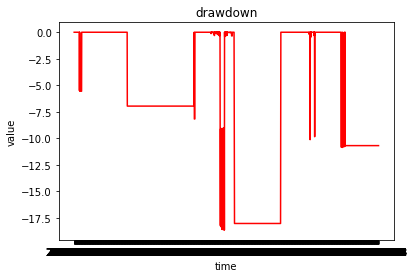

<Figure size 1080x288 with 0 Axes>

,dates,asset,type,value
0,2016-01-20,CEF,B,4.880547
1,2016-01-29,NAV,S,6.575399
2,2016-01-29,CEF,S,5.288630
3,2016-02-01,NAV,S,6.630459
4,2016-02-03,NAV,S,6.716978
...,...,...,...,...
541,2023-02-01,CEF,B,10.750134
542,2023-02-15,CEF,S,10.778056
543,2023-02-16,CEF,B,10.731517
544,2023-02-17,CEF,S,10.796671


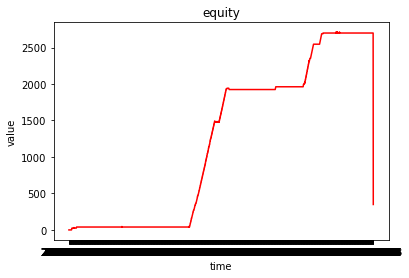

<Figure size 1080x288 with 0 Axes>

In [14]:
backtest_ind()

#### We can see t
1. The positions at the end that needed closing out
2. max drawdown and time before closing out
3. the holdings affter closing out (0,0)
4. gross profit 
5. percentage of profit
6. the maximum drawdown and the time it occured

#### Keep in mind the length of the data is 2011 days.

## Now that we have a strategy that seems well, we will attempt to replicate it by finding a proxy for the NAV by using its the top constituents of the CEF.

In [15]:
print(y_data.columns.values)
y_data = y_data.drop(('Adj Close', 'PEG'), axis=1)
print(y_data.columns.values)
#Here we drop PEG, as I observed from the regression that its contribution was minimal

[('Adj Close', 'CMS') ('Adj Close', 'CNP') ('Adj Close', 'LNG')
 ('Adj Close', 'NI') ('Adj Close', 'OGE') ('Adj Close', 'PEG')
 ('Adj Close', 'SO') ('Adj Close', 'SRE') ('Adj Close', 'WEC')
 ('Adj Close', 'XEL')]
[('Adj Close', 'CMS') ('Adj Close', 'CNP') ('Adj Close', 'LNG')
 ('Adj Close', 'NI') ('Adj Close', 'OGE') ('Adj Close', 'SO')
 ('Adj Close', 'SRE') ('Adj Close', 'WEC') ('Adj Close', 'XEL')]


In [16]:
import statsmodels.api as sm
model = sm.OLS(nav_p,y_data['Adj Close']).fit()
results = model.summary()
#Here is the model and its summary, regressing 9 of the constituents onto the NAV value
#We see that the r^2 is very high, meaning we (should)nhave a good proxy
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  XDNPX   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.041e+05
Date:                Tue, 09 Jan 2024   Prob (F-statistic):                        0.00
Time:                        17:18:04   Log-Likelihood:                         -944.39
No. Observations:                2017   AIC:                                      1907.
Df Residuals:                    2008   BIC:                                      1957.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CMS            0.0145      0.009      1.526      0.127      -0.004       0.033
CNP            0.0950      0.007     12.919      0.000       0.081       0.109
LNG           -0.0208      0.001    -26.459      0.000      -0.022      -0.019
NI             0.1809      0.008     21.808      0.000       0.165       0.197
OGE            0.0279      0.007      3.935      0.000       0.014       0.042
SO             0.0891      0.003     26.853      0.000       0.083       0.096
SRE           -0.0515      0.005    -10.879      0.000      -0.061      -0.042
WEC           -0.0406      0.006     -6.822      0.000      -0.052      -0.029
XEL            0.0618      0.007      8.356      0.000       0.047       0.076
==============================================================================
Omnibus:                       18.953   Durbin-Watson:                   0.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.376
Skew:                           0.148   Prob(JB):                     8.39e-06
Kurtosis:                       3.437   Cond. No.                         226.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
print(model.params.values) #Observing coefficients
symbols = top_symbols['Symbol'].values[:10]
symbols = sorted(symbols) #Sorting to align with y_data columns
symbols.remove("PEG") #Removing PEG again as it was not significant
symbols = [str(i) for i in symbols] #returning the symbols to strings
coeffs = model.params.values #assigning coefficients to a variable
y_coeff = y_data.copy(deep=True) #create a copy of the y_data to avoid overwriting original
for i, s in enumerate(symbols):
    y_coeff['Adj Close', s]*=coeffs[i] #we will multiply each ticker's price data by its respective coefficient of regression
print(y_coeff['Adj Close']) #we observe the weighted prices

#Below we print the coefficients of the model, as well as the now weighted values of each asset
#These weighted values will be used to compute the value of purchasing/shorting one unit of our NAV Proxy for any day

[ 0.01449315  0.09501475 -0.02078772  0.18093309  0.02794285  0.08909889
 -0.05146254 -0.04057238  0.06182545]
                 CMS       CNP       LNG        NI       OGE        SO  \
Date                                                                     
2016-01-04  0.408464  1.313973 -0.761905  2.735640  0.523546  2.950653   
2016-01-05  0.411675  1.326200 -0.781405  2.779085  0.518803  2.971357   
2016-01-06  0.412249  1.309658 -0.752765  2.794501  0.514309  2.971986   
2016-01-07  0.414773  1.283767 -0.710312  2.732837  0.503923  2.946890   
2016-01-08  0.414084  1.280890 -0.711125  2.728632  0.509515  2.924931   
...              ...       ...       ...       ...       ...       ...   
2024-01-02  0.858139  2.756378 -3.521648  4.887003  0.977881  6.312656   
2024-01-03  0.859299  2.767779 -3.520609  4.865291  0.982576  6.436504   
2024-01-04  0.860603  2.763029 -3.510215  4.859863  0.986718  6.389281   
2024-01-05  0.860023  2.778231 -3.483399  4.892431  0.992251  6.380372   
2

In [18]:
print(sum(y_coeff.iloc[0].values)) #The value of the proxy on the first day is below

5.815142167564693


In [19]:
def trade_hedge(index):
    price = sum(y_coeff.iloc[i].values)
    return price
#Function to return the value of the proxy on the ith date.

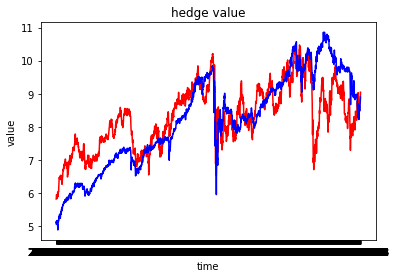

In [20]:
hedge_vals = []
for i in range(len(cef_p)):
    hedge_vals.append(sum(y_coeff.iloc[i].values))
plt.clf()
plt.plot(dates, hedge_vals, color = 'r')
plt.plot(dates, cef_p, color = 'b')
plt.title("hedge value")
plt.xlabel("time")
plt.ylabel("value")
plt.show()

## Now we run a backtest of the same strategy, but using the proxy rather than the NAV. 

In [48]:
def backtest_hedge():
    capital = 1000
    buys = []
    sells = []
    max_drawdown = [0,0]
    current_pos = 0
    holdings = {'cef':0,
               'hedge':0}
    trade_dates = []
    trade_types = []
    trade_values = []
    trade_assets = []
    equity = []
    drawdowns = []
    z_scores = []
    shorted = 0
    def trade(index, pos, asset):
        if asset == 'cef':
            value = cef_p[i]
            trade_assets.append('CEF')
            if pos == 's':
                holdings['cef']-=1
                trade_types.append('S')
                sells.append(value)
            if pos == 'b':
                holdings['cef']+=1
                trade_types.append('B')
                buys.append(value)
        else:
            value = trade_hedge(i)
            trade_assets.append('Hedge')
            if pos == 's':
                holdings['hedge']-=1
                trade_types.append('S')
                sells.append(value)
            if pos == 'b':
                holdings['hedge']+=1
                trade_types.append('B')
                buys.append(value)
        trade_values.append(value)
        trade_dates.append(dates[i])
    lag = 5
    for i in range(lag, len(nav_p)):
        nav_ptd = nav_p[i-lag:i+1]
        cef_ptd = cef_p[i-lag:i+1]
        nav_m = mean(nav_ptd)
        cef_m = mean(cef_ptd)
        nav_std = nav_ptd.std()
        cef_std = cef_ptd.std()
        if z_score(trade_hedge(i),nav_m, nav_std)>(30/math.sqrt(i))+ 2 :
            trade(i, 's', 'hedge')
            current_pos+=trade_hedge(i)
            z_scores.append(z_score(trade_hedge(i),nav_m, nav_std))
            trade(i, 'b', 'cef')
            current_pos-=cef_p[i]
            if holdings['hedge']<0:
                shorted += trade_hedge(i)
        elif abs(z_score(trade_hedge(i),nav_m, nav_std))>(30/math.sqrt(i))+2:
            trade(i, 'b', 'hedge')
            current_pos-=trade_hedge(i)
            z_scores.append(z_score(trade_hedge(i),nav_m, nav_std))
            trade(i, 's', 'cef')
            current_pos+=cef_p[i]
            if holdings['hedge']<=0:
                shorted -= trade_hedge(i)
        if z_score(cef_p[i],cef_m, cef_std)>(30/math.sqrt(i))+2:
            trade(i, 's', 'cef')
            current_pos+=cef_p[i]
            z_scores.append(z_score(cef_p[i],cef_m, cef_std))
            trade(i, 'b', 'hedge')
            current_pos-=trade_hedge(i)
            if holdings['cef']<0:
                shorted += cef_p[i]
        elif abs(z_score(cef_p[i],cef_m, cef_std))>(30/math.sqrt(i))+2:
            trade(i, 'b', 'cef')
            current_pos-=cef_p[i]
            z_scores.append(z_score(cef_p[i],cef_m, cef_std))
            trade(i, 's', 'hedge')
            current_pos+=trade_hedge(i)
            if holdings['cef']<=0:
                shorted-=cef_p[i]
        if current_pos<max_drawdown[0]:
            max_drawdown = [current_pos, i]
        if holdings['cef']>=0 and holdings['hedge']>=0:
            shorted = 0
        if i>30 and current_pos<(-(max(abs(0.5*(sum(sells)-sum(buys))), 0))):
            if holdings['hedge']>0:
                sells.append(holdings['hedge']*trade_hedge(i))
                current_pos+=holdings['hedge']*trade_hedge(i)
                trade_values.append(holdings['hedge']*trade_hedge(i))
                holdings['hedge'] = 0
                trade_dates.append(dates[i])
                trade_types.append('S')
                trade_assets.append('Hedge')
            if holdings['cef']>0:
                sells.append(holdings['cef']*cef_p[i])
                current_pos+=holdings['cef']*cef_p[i]
                trade_values.append(holdings['cef']*cef_p[i])
                trade_assets.append('CEF')
                holdings['cef'] = 0
                trade_dates.append(dates[i])
                trade_types.append('S')
        elif i > 30 and shorted > ((sum(sells)-sum(buys))/2):
            print(f"shorted: {shorted}, profit: {sum(sells)-sum(buys)}")
            print(holdings['hedge'])
            print(holdings['cef'])
            if holdings['hedge']<0:
                buys.append(holdings['hedge']/2*trade_hedge(i))
                current_pos+=holdings['hedge']/2*trade_hedge(i)
                trade_values.append(holdings['hedge']/2*trade_hedge(i))
                shorted+=holdings['hedge']/2*trade_hedge(i)
                holdings['hedge'] = holdings['hedge']/2
                trade_dates.append(dates[i])
                trade_types.append('B')
                trade_assets.append('Hedge')
            if holdings['cef']<0:
                buys.append(holdings['cef']/2*cef_p[i])
                current_pos+=holdings['cef']/2*cef_p[i]
                trade_values.append(holdings['cef']/2*cef_p[i])
                trade_assets.append('CEF')
                shorted+=holdings['cef']/2*cef_p[i]
                holdings['cef'] = holdings['cef']/2
                trade_dates.append(dates[i])
                trade_types.append('B')
        if current_pos>0:
            current_pos = 0
        equity.append(sum(sells)-sum(buys)-shorted)
        drawdowns.append(current_pos)
    print(holdings.values())
    print(max_drawdown)
    if holdings['cef']>0:
        sells.append(holdings['cef']*cef_p[-1])
        holdings['cef']=0
    elif holdings['cef']<0:
        buys.append(-holdings['cef']*cef_p[-1])
        current_pos-=holdings['cef']*cef_p[-1]
        holdings['cef']=0
    if holdings['hedge']>0:
        sells.append(holdings['hedge']*nav_p[-1])
        holdings['hedge']=0
    elif holdings['hedge']<0:
        buys.append(-holdings['hedge']*nav_p[-1])
        current_pos-=holdings['hedge']*nav_p[-1]
        holdings['hedge']=0
    if current_pos<max_drawdown[0]:
        max_drawdown = [current_pos,len(nav_p)-1]
    equity.append(sum(sells)-sum(buys))
    
    print(holdings.values())
    print(sum(sells)-sum(buys))
    print(((sum(sells)/sum(buys))-1)*100)
    print(max_drawdown)
    plt.clf()
    plt.plot(dates[lag:], drawdowns, color = 'r')
    plt.title("drawdown")
    plt.xlabel("time")
    plt.ylabel("value")

# Show the plot
    plt.show()
    trade_log = pd.DataFrame(data = {'dates': trade_dates, 'asset':trade_assets, 'type': trade_types, 'value':trade_values})
    display(trade_log)
    plt.clf()
    x_dates = dates.copy()
    x_dates+='1'
    plt.plot(x_dates[lag:], equity, color = 'r')
    plt.title("equity")
    plt.xlabel("time")
    plt.ylabel("value")

# Show the plot
    plt.show()
#     plt.clf()
#     plt.plot(range(len(z_scores)), z_scores, color = 'r')
#     plt.show()

shorted: 244.18612402154375, profit: 103.89421146584917
-27
27
shorted: 131.13699253008824, profit: 229.66338802456303
-14.5
28
shorted: 264.5349676900056, profit: 526.5984521310421
-29.25
21
shorted: 376.45360786654675, profit: 746.8473909988697
-41.625
48
shorted: 531.8961636672985, profit: 1052.502127721436
-58.8125
86
shorted: 736.2324688381041, profit: 1465.0217931957438
-81.40625
138
shorted: 1028.3231623291506, profit: 2049.420009216759
-113.703125
211
shorted: 1409.5107025769034, profit: 2809.8411441323624
-155.8515625
310
shorted: 1889.5102493189115, profit: 3765.835370769074
-208.92578125
441
shorted: 2527.442965539836, profit: 5053.747427724362
-279.462890625
616
shorted: 3343.8255022126878, profit: 6680.153453427982
-369.7314453125
846
dict_values([166, -351.86572265625])
[-4278.339914226526, 1126]
dict_values([0, 0])
14326.850413797403
144.14845804495607
[-4278.339914226526, 1126]


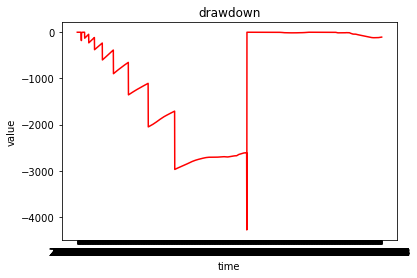

,dates,asset,type,value
0,2016-01-11,Hedge,S,9.043931
1,2016-01-11,CEF,B,5.161360
2,2016-01-12,Hedge,S,9.043931
3,2016-01-12,CEF,B,5.110815
4,2016-01-13,Hedge,S,9.043931
...,...,...,...,...
3388,2024-01-04,CEF,B,8.740000
3389,2024-01-05,Hedge,S,9.043931
3390,2024-01-05,CEF,B,8.840000
3391,2024-01-08,Hedge,S,9.043931


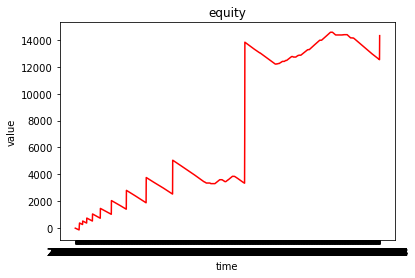

In [49]:
backtest_hedge() 

### Again, we observe 
1. The holdings before closing out
2. The max drawdown and time it occurred before closing
3. The holdings after closing (0,0)
4. The gross profit
5. The ROI
6. The final max drawdown and time it occurred